### Manual Training Using `tf.GradientTape()`

In [61]:
import tensorflow as tf
import numpy as np

In [62]:
# Load MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

In [63]:
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)
y_train_onehot = tf.one_hot(y_train, 10)
y_test_onehot = tf.one_hot(y_test, 10)

In [64]:
# Hyperparameters
learning_rate = 0.001
epochs = 5
batch_size = 64

In [65]:
# Weights & Biases Initialization
W1 = tf.Variable(tf.random.normal([784, 256], stddev=0.1))
b1 = tf.Variable(tf.zeros([256]))

W2 = tf.Variable(tf.random.normal([256, 128], stddev=0.1))
b2 = tf.Variable(tf.zeros([128]))

W3 = tf.Variable(tf.random.normal([128, 64], stddev=0.1))
b3 = tf.Variable(tf.zeros([64]))

W4 = tf.Variable(tf.random.normal([64, 10], stddev=0.1))
b4 = tf.Variable(tf.zeros([10]))


In [66]:
loss_history1 = []
accuracy_history1 = []

# Create training dataset
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_onehot)).shuffle(10000).batch(batch_size)

for epoch in range(epochs):
    epoch_loss = 0
    correct_predictions = 0
    total_samples = 0

    for step, (x_batch, y_batch) in enumerate(train_ds):
        with tf.GradientTape() as tape:
            # Forward pass
            h1 = tf.nn.relu(tf.matmul(x_batch, W1) + b1)
            h2 = tf.nn.relu(tf.matmul(h1, W2) + b2)
            h3 = tf.nn.relu(tf.matmul(h2, W3) + b3)
            logits = tf.matmul(h3, W4) + b4

            # Loss
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_batch, logits=logits))

        # Gradients & parameter update
        gradients = tape.gradient(loss, [W1, b1, W2, b2, W3, b3, W4, b4])
        for var, grad in zip([W1, b1, W2, b2, W3, b3, W4, b4], gradients):
            var.assign_sub(learning_rate * grad)

        epoch_loss += loss.numpy()

        # Accuracy calculation
        predictions = tf.argmax(logits, axis=1)
        labels = tf.argmax(y_batch, axis=1)
        correct_predictions += tf.reduce_sum(tf.cast(predictions == labels, tf.float32)).numpy()
        total_samples += x_batch.shape[0]

    accuracy = correct_predictions / total_samples
    avg_loss = epoch_loss / (step + 1)

    loss_history1.append(avg_loss)
    accuracy_history1.append(accuracy)

    print(f"Epoch {epoch + 1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}")


Epoch 1: Loss = 2.1541, Accuracy = 0.2930
Epoch 2: Loss = 1.6442, Accuracy = 0.5871
Epoch 3: Loss = 1.1334, Accuracy = 0.7105
Epoch 4: Loss = 0.8390, Accuracy = 0.7767
Epoch 5: Loss = 0.6824, Accuracy = 0.8133


In [67]:
# Evaluation
def evaluate(x, y):
    h1 = tf.nn.relu(tf.matmul(x, W1) + b1)
    h2 = tf.nn.relu(tf.matmul(h1, W2) + b2)
    h3 = tf.nn.relu(tf.matmul(h2, W3) + b3)
    logits = tf.matmul(h3, W4) + b4
    preds = tf.argmax(logits, axis=1)
    true = tf.argmax(y, axis=1)
    acc = tf.reduce_mean(tf.cast(tf.equal(preds, true), tf.float32))
    return acc

test_acc = evaluate(x_test, y_test_onehot)
print(f"Test Accuracy: {test_acc.numpy() * 100:.2f}%")

Test Accuracy: 82.96%


### Keras `model.fit()` Training


In [68]:
from tensorflow.keras import layers, models, Input

# Define input
inputs = Input(shape=(784,))

# Hidden layers
x = layers.Dense(256, activation='relu')(inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)

# Output layer
outputs = layers.Dense(10)(x)

model = models.Model(inputs=inputs, outputs=outputs)
model.summary(show_trainable = True)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_5 (InputLayer)  │ (None, 784)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_20 (Dense)            │ (None, 256)           │    200,960 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_21 (Dense)            │ (None, 128)           │     32,896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_22 (Dense)            │ (None, 64)            │      8,256 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_23 (Dense)            │ (None, 10)            │        650 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 242,762 (948.29 KB)

 Trainable params: 242,762 (948.29 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:

model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

history = model.fit(x_train, y_train_onehot, epochs=5, batch_size=64)

loss, acc = model.evaluate(x_test, y_test_onehot)
print(f"Test Accuracy: {acc * 100:.2f}%")


Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9891 - loss: 0.0325
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9931 - loss: 0.0200
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9923 - loss: 0.0232
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9945 - loss: 0.0166
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9938 - loss: 0.0185
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9760 - loss: 0.1026
Test Accuracy: 97.97%


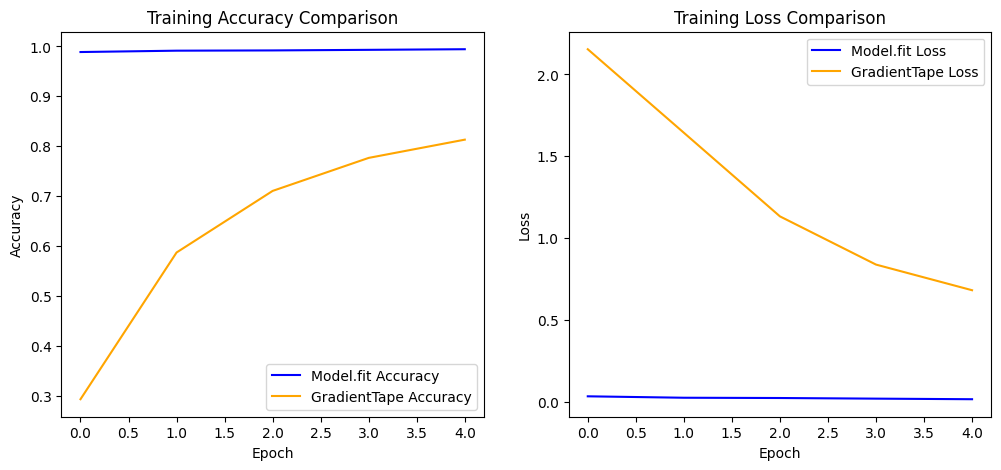

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy comparison plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Model.fit Accuracy', color='blue')
plt.plot(accuracy_history1, label='GradientTape Accuracy', color='orange')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss comparison plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Model.fit Loss', color='blue')
plt.plot(loss_history1, label='GradientTape Loss', color='orange')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
